In [47]:
import time
import toml
import numpy as np
import matplotlib.pyplot as plt
#from ref_trajectory import generate_trajectory as traj
%matplotlib inline

In [48]:
v = 1
dt = 0.1
num_st_pts = int(v/dt)
num_pts = 50

def cubic_spiral(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    #-2*x**3 + 3*x**2
    return (theta_f-theta_i)*(-2*x**3 + 3*x**2) + theta_i
   
def straight(dist, curr_pose, n=num_st_pts):
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    x0, y0, t0 = curr_pose
    xf, yf = x0 + dist*np.cos(t0), y0 + dist*np.sin(t0)
    x = (xf - x0) * np.linspace(0, 1, n) + x0
    y = (yf - y0) * np.linspace(0, 1, n) + y0
    return x, y, t0*np.ones_like(x)

def turn(change, curr_pose, n=num_pts):
    # adjust scaling constant for desired turn radius
     x0, y0, t0 = curr_pose
     theta = cubic_spiral(t0, t0 + np.deg2rad(change), n)
     x= x0 + np.cumsum(v*np.cos(theta)*dt)
     y= y0 + np.cumsum(v*np.sin(theta)*dt)
     return x, y, theta

def generate_trajectory(route, init_pose = (0, 0,np.pi/2)):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command, curr_pose)
        curr_pose = px[-1],py[-1],pt[-1]
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
        t = np.concatenate([t, pt])
        
    return np.vstack([x, y, t])
traj = generate_trajectory

There are a lot of configuration parameters. It is a good idea to separate it from the main code. At some point you will be doing parameter tuning. 

We will use toml format to store parameters. Open config.toml and go over the description of the different parameters we may use here

Read the config parameters, default output is a dictionary. You have to then store them as local variables. 
You have 2 options for this
1. update locals() directly - a little bit dangerous
2. You can use itemgetter

In [49]:
config_params = toml.load("config.toml")['params']
print(config_params)
locals().update(config_params)
print(dt, V_MAX)

{'dt': 0.1, 'V_MAX': 1.2, 'W_MAX': 1.0, 'K_MAX': 0.5, 'MIN_DIST': 1.0, 'ACC_MAX': 0.5, 'W_DOT_MAX': 3.0, 'LATERAL_ACC_MAX': 1.5, 'goal_threshold': 0.05, 'pred_horizon': 10, 'w_cte': 1.0, 'w_speed': 1.0}
0.1 1.2


There are 3 functions we need to write for DWA

1. Simulate unicyle - we will slightly modify it to simulate $N$ steps 

2. Command Window - Entire set of acceptable $(v, \omega)$ in that time instant given current $(v, \omega)$$

3. track - get $(v, \omega )$ for path with the lowest cost

In the first iteration, let us not integrate collision checking. Let us integrate these pieces, make sure DWA works for a few paths!

In [50]:
v_min, v_max = 0.0, 0.2
w_min, w_max = -0.1, 0.1
vs = np.linspace(v_min, v_max, num=11)
ws = np.linspace(w_min, w_max, num=11)
cmd = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
print(cmd[65])

[0.2 0. ]


In [63]:
def circle_collision_check(grid, local_traj):
    xmax, ymax = grid.shape
    all_x = np.arange(xmax)
    all_y = np.arange(ymax)
    X, Y = np.meshgrid(all_x, all_y)
    r = 0.5
    l = 0.4
    grid_res = 0.05
    circles = [(0, 0, r), (0, l, r), (0, -l, r)]
    for xl, yl, tl in local_traj:
      rot = np.array([[np.sin(tl), -np.cos(tl)],[np.cos(tl), np.sin(tl)]])
      for xc, yc, rc in circles:
        xc_rot, yc_rot = rot @  np.array([xc, yc]) + np.array([xl, yl])
        xc_pix, yc_pix = int(xc_rot/grid_res), int(yc_rot/ grid_res)
        rc_pix = (rc/ grid_res)
        inside_circle = ((X-xc_pix)**2 +(Y-yc_pix)**2 - rc_pix**2 < 0)
        occupied_pt = grid[X, Y] == 1
        if np.sum(np.multiply( inside_circle, occupied_pt)):
          return True
    return False

In [98]:
def simulate_unicycle(pose, v, w, N=1, dt=0.1):
    x, y, t = pose
    poses = []
    for _ in range(N):
        x += v*np.cos(t)*dt
        y += v*np.sin(t)*dt
        t += w*dt
        poses.append([x,y,t])
    return np.array(poses)

def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min(V_MAX, v + ACC_MAX*dt)
    v_min = max(0, v - ACC_MAX*dt)
    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    epsilon = 1e-6
    w_max = min(W_MAX, w + W_DOT_MAX*dt)
    w_min = max(-W_MAX, w - W_DOT_MAX*dt)
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=11)
    ws = np.linspace(w_min, w_max, num=21)
    
    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
    
    #calculate kappa for the set of commands
    kappa = commands[:,1]/(commands[:,0]+epsilon)
    
    #returning only commands < max curvature 
    return commands[(kappa < K_MAX) & (commands[:, 0] != 0)]

def track(ref_path, pose, v, w):
    commands = command_window(v, w, dt)
    #initialize path cost
    best_cost, best_command = np.inf, None

    for i, (v, w) in enumerate(commands):
        local_path = simulate_unicycle(pose, v, w) #Number of steps = prediction horizon
        grid = np.zeros([50, 50])

        #calculate cross-track error
        #can use a simplistic definition of 
        #how close is the last pose in local path from the ref path
        
        cte = np.sqrt((local_path[-1][0]-local_ref_path[-1][0])**2+(local_path[-1][1]-local_ref_path[-1][1])**2)
        
        #other cost functions are possible
        #can modify collision checker to give distance to closest obstacle
        cost = w_cte*cte + w_speed*(V_MAX - v)**2 
        
        #check if there is a better candidate
        if np.any(cost < best_cost):
            best_cost, best_command = cost, (v, w)

    if best_command:
        return best_command
    else:
        return [0, 0]


In [72]:
# just checking for the error 
start_pose = np.array([0, 0, np.pi/2])
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
ref_path = traj(route, start_pose).T
pose = start_pose
path_index = 0
local_ref_path = ref_path[path_index:path_index+pred_horizon]
x, y = pose[0], pose[1]
xr, yr = local_ref_path[-1][0], local_ref_path[-1][1]
if np.sqrt((xr-x)**2 + (yr-y)**2) > goal_threshold*10:
  path_index += 1
print(path_index)
###################################

1


In [100]:
sush = np.array([1, 2]) + np.array([1, 2])
rot = np.array([[np.sin(0), -np.cos(0)],[np.cos(0), np.sin(0)]])
surya = rot @ sush
print(surya.shape)
surya

(2,)


array([-4.,  2.])

In [ ]:
start_pose = np.array([0, 0, np.pi/2])
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
ref_path = traj(route, start_pose).T

pose = start_pose
print(pose[1])
#print(pose[2])
logs = []
path_index = 0
v, w = 0.0, 0.0
while path_index < len(ref_path)-1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    # update path_index using current pose and local_ref_path
        
    xp = pose[0]
    #yp = pose[1]
    xr, yr = local_ref_path[-1][0], local_ref_path[-1][1]

    if np.any(np.sqrt((xr-0)**2 + (yr-0)**2)) < goal_threshold*10:
           path_index += 1
        
    # get next command

    v, w = track(ref_path, pose, v, w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(pose, v, w)
    
    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")


<IPython.core.display.Javascript object>


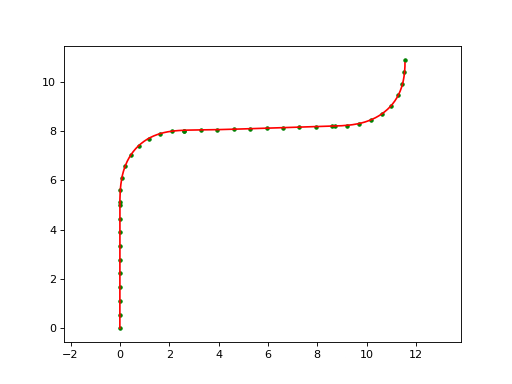

In [ ]:
poses = np.array(logs)[:,:3]
plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g')
plt.plot(poses[:,0], poses[:,1], c='r')

Now it should be relatively straight-forward to integrate collision checking in the grid environment the robot is going to navigate